In [1]:
%reload_ext Cython

%reload_ext autoreload
%autoreload 2

from copy import deepcopy
from datetime import datetime, timedelta
from file_exchange import config, network
from file_exchange.network import Network
from file_exchange.peers_view import PeersView
from file_exchange.user import User
from gevent.event import AsyncResult
from gevent.pool import Group
from gevent.select import select
import gevent
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import pandas as pd
import os
import pickle
import random
import re
import seaborn as sns
import shutil
import sys
import time
import traceback

def load_conf(path):
    f = open(path+'conf.json', 'r')
    conf = json.load(f)
    conf['period'] = datetime.strptime(conf['period'], "%H:%M:%S") - \
                      datetime.strptime("00:00", "%H:%M")
    return conf 

def fetch_dataframes(conf):
    devices_df = pd.DataFrame()
    users_df = pd.DataFrame()
    for fn in os.listdir(conf['output_dir']):
        if not fn.endswith(".csv"):
            continue
            
        filepath = conf['output_dir']+fn
        if re.search("device", fn):
            devices_df = append_to_df(filepath, devices_df)
        elif re.search("user", fn):
            users_df = append_to_df(filepath, users_df)

    devices_df['t'] -= min(devices_df['t'])
    devices_df = devices_df.sort_values('t')
    users_df['t'] -= min(users_df['t'])
    users_df = users_df.sort_values('t')
    return devices_df, users_df

def fetch_experiment_data(path):
    conf = load_conf(path)
    with open(conf['output_dir']+"files_info.bin", 'rb') as f:
        files_info = pickle.load(f)
    devices_df, users_df = fetch_dataframes(conf)  
    return conf, files_info, devices_df, users_df

def append_to_df(filepath, df):
    try:
        df2 = pd.read_csv(filepath)
    except:
        print("Failed loading {}: {}".format(fn, sys.exc_info()))
        pass
    else:
        if(df.empty):
            df = df2
        else:
            df = df.append(df2,)
    return df

# if experiment_set:
#     data_dir = 'data/'+experiment_set_name+''/'+conf['experiment_name']+'/'
# else:
#     data_dir = "data/"+conf['experiment_name']+'/'
# #data_dir="data/experiment_set/experiment_1/"
# conf, files_info, devices_df, users_df = fetch_experiment_data(data_dir)

In [2]:
def fetch_experiment_set(path):
    devices_df = pd.DataFrame()
    users_df = pd.DataFrame()
    conf = {}
    files_info = {}
    for experiment_name in os.listdir(path):
        conf_, files_info_, devices_df_, users_df_ = \
            fetch_experiment_data(path+experiment_name+"/")
        
        devices_df_['experiment_name'] = experiment_name
        users_df_['experiment_name'] = experiment_name
        devices_df = devices_df.append(devices_df_, ignore_index=True)
        users_df = users_df.append(users_df_, ignore_index=True)
        conf[experiment_name] = conf_
        files_info[experiment_name] = files_info_
    return conf, files_info, devices_df, users_df

# Mesage IDs are not unique in the dataset! (experiment_id, mes_id) should be
conf, files_info, devices_df, users_df =  fetch_experiment_set("data/random_file_size/")

## RTT

In [7]:
%%cython

import numpy as np
import pandas as pd 

def get_transfer_times(devices_df):
    assert(devices_df['mess_id'].unique().shape[0] == \
      np.unique(
          devices_df[['experiment_id', 'mess_id']].values.astype(np.uint), 
          axis=0).shape[0])
    
    messages_id = devices_df['mess_id'].unique()
    transfer_times = pd.DataFrame()

    cdef long n_messages = messages_id.shape[0]
    cdef long i, m_id
    cdef char success, invalid
    cdef float[2] times
    cdef int[2] n_hops
#     cdef float[2] times
    
    for i, m_id in enumerate(messages_id):
        times = [-1] * 2
        n_hops = [-1] * 2
        success = True
        invalid = False
        
        for typ in [1, 2]:
            data = devices_df[(devices_df['mess_id'] == m_id) & 
                              (devices_df['type'] == typ)]
            data_sent = data[data['sent'] != 0]['t']
            data_received = data[data['received'] != 0]['t']
            
            
            
            if data_sent.shape[0] != 1 or data_received.shape[0] > 1:
                invalid = True
                break
            
            n_hops[typ-1] = data[data['forwarded'] != 0].shape[0]
            if data_sent.shape[0] == 1 and data_received.empty:
                success = False
                break
            
            # Reached its destination: +1 hop
            n_hops[typ-1] += 1
            times[typ-1] = data_received.values[0] - data_sent.values[0]
                
        if invalid:
            continue
            
        transfer_times = transfer_times.append(pd.Series({
            'mess_id': m_id, 
            'success': success,
            'chunk_time': times[0] if times[0] != -1 else None,
            'ack_time': times[1] if times[1] != -1 else None,
            'chunk_n_hops': n_hops[0] if n_hops[0] != -1 else None,
            'ack_n_hops': n_hops[1] if n_hops[1] != -1 else None,
        }), ignore_index=True)
        
        # Debug
        if i % 10000 == 0:
            print("{:.1%} done".format((i+1)/n_messages))
        i += 1
    return transfer_times

In [ ]:
transfer_times = get_transfer_times(devices_df)
transfer_times.to_csv("outputs/transfer_times_random_file_size.csv")

0.0% done
6.7% done


In [ ]:
PLOT_DIR = "outputs/users_number/"
os.makedirs(PLOT_DIR)

In [105]:
def to_cdf(data):
    data_size = len(data)
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)
    counts, bin_edges = np.histogram(data, bins=bins, density=False)

    counts=counts.astype(float)/data_size

    # Find the cdf
    cdf = np.cumsum(counts)
    
    return cdf, bins

def to_cdf_2(data, n_bins):
    data_size = data.shape[0]
    
    counts, bin_edges = np.histogram(data, bins=n_bins)
    cdf = np.cumsum(counts/data_size)
    
    return cdf, bin_edges

N_BINS = 100
not_na_tt = transfer_times[transfer_times['t'].notna()]
chunk_cdf, chunk_bins = to_cdf_2(not_na_tt[not_na_tt['type'] == 1]['t'], N_BINS)
ack_cdf, ack_bins = to_cdf_2(not_na_tt[not_na_tt['type'] == 2]['t'], N_BINS)
rtt_cdf, rtt_bins = to_cdf_2(not_na_tt[not_na_tt['type'] == 3]['t'], N_BINS)

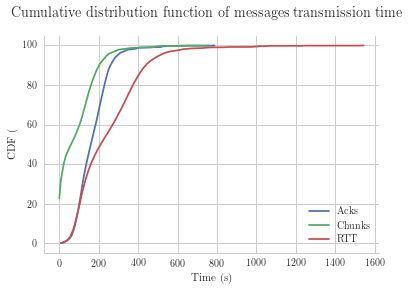

In [108]:
f, ax = plt.subplots()
sns.set_context('paper')
sns.set(font='serif')
sns.set_style("whitegrid", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

# Plot the cdf
ax.plot(ack_bins[0:-1], ack_cdf, label="Acks")
ax.plot(chunk_bins[0:-1], chunk_cdf, label="Chunks")
ax.plot(rtt_bins[0:-1], rtt_cdf, label="RTT")

ax.set_xlabel('Time (s)')
#ax.set_xlim(0,)
ax.set_ylabel('CDF (%)')
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
#ax.set_ylim(0,)
ax.legend()
plt.suptitle('Cumulative distribution function of messages transmission time')


sns.despine()
plt.savefig('outputs/messages_rtt_cdf_n_users.svg')
plt.show()